# Download Dataset from Kaggle

In [ ]:
!kaggle datasets download -d muhammadmasdar/tooth-numbering

Dataset URL: https://www.kaggle.com/datasets/muhammadmasdar/tooth-numbering
License(s): unknown
 95% 289M/305M [00:02<00:00, 136MB/s]
100% 305M/305M [00:02<00:00, 119MB/s]


In [ ]:
!unzip tooth-numbering.zip

Streaming output truncated to the last 5000 lines.
  inflating: teeth detection and numbering.v18i.yolov7pytorch/train/images/1000_F_244677583_NweTDkYILYwSnYrqIeVEeE211JGiZ0In_jpg.rf.70112354aef899df51a86ef910e3b960.jpg  
  inflating: teeth detection and numbering.v18i.yolov7pytorch/train/images/1000_F_244677583_NweTDkYILYwSnYrqIeVEeE211JGiZ0In_jpg.rf.c70be3868785b561f674a7757bfb8a81.jpg  
  inflating: teeth detection and numbering.v18i.yolov7pytorch/train/images/1001_jpg.rf.38d520a1843a52c94c046a6da766cf7c.jpg  
  inflating: teeth detection and numbering.v18i.yolov7pytorch/train/images/1001_jpg.rf.7c092eb97fccee4ae3d9778e8bcf497e.jpg  
  inflating: teeth detection and numbering.v18i.yolov7pytorch/train/images/1004_jpg.rf.7d60110f5fb8330418d02fdfe65c20de.jpg  
  inflating: teeth detection and numbering.v18i.yolov7pytorch/train/images/1004_jpg.rf.b83b0bde2b85fe12df4dc79145456a66.jpg  
  inflating: teeth detection and numbering.v18i.yolov7pytorch/train/images/1005_jpg.rf.63f7a33209c444aa

# Saving Dataset for later use 

In [ ]:
import os
source_folder = '/content/teeth detection and numbering.v18i.yolov7pytorch'
destination_folder = '/content/drive/MyDrive/teeth_detection_dataset'

!cp -r "{source_folder}" "{destination_folder}"

# Imports Necessary Modules

In [12]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pathlib
import os
import seaborn as sns
import pandas as pd
import shutil
import albumentations as A
from glob import glob
import random
from collections import defaultdict
from matplotlib.patches import Polygon
from pathlib import Path
from PIL import Image

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Paths

In [ ]:
base_dir = '/content/drive/MyDrive/teeth_detection_dataset'
train_dir = f'{base_dir}/train'
valid_dir = f'{base_dir}/valid'
test_dir = f'{base_dir}/test'

# Dataset Distribution: Train Set

In [ ]:
print("Train set:\n========================================")
print(f"{len(os.listdir(os.path.join(train_dir, 'images')))} images")
print(f"{len(os.listdir(os.path.join(train_dir, 'labels')))} labels")

Train set:
2250 images
2250 labels


# Dataset Distribution: Valid Set

In [ ]:
print("Valid set:\n========================================")
print(f"{len(os.listdir(os.path.join(valid_dir, 'images')))} images")
print(f"{len(os.listdir(os.path.join(valid_dir, 'labels')))} labels")

Valid set:
250 images
250 labels


# Dataset Distribution: Test Set

In [ ]:
print("Test set:\n========================================")
print(f"{len(os.listdir(os.path.join(test_dir, 'images')))} images")
print(f"{len(os.listdir(os.path.join(test_dir, 'labels')))} labels")

Test set:
28 images
28 labels


# Viewing YOLO Dataset Configuration (data.yaml)

In [ ]:
file_path = '/content/drive/MyDrive/teeth_detection_dataset/data.yaml'
with open(file_path, 'r') as file:
    content = file.read()
    print(content)


train: /content/drive/MyDrive/teeth_detection_dataset/train/images
val: /content/drive/MyDrive/teeth_detection_dataset/valid/images
test: /content/drive/MyDrive/teeth_detection_dataset/test/images

nc: 32
names: ['11', '12', '13', '14', '15', '16', '17', '18', '21', '22', '23', '24', '25', '26', '27', '28', '31', '32', '33', '34', '35', '36', '37', '38', '41', '42', '43', '44', '45', '46', '47', '48']

roboflow:
  workspace: prime-snf1v
  project: teeth-detection-and-numbering-agi2i
  version: 18
  license: MIT
  url: https://universe.roboflow.com/prime-snf1v/teeth-detection-and-numbering-agi2i/dataset/18


# Distribution of Tooth Instances Across Train, Validation, and Test Sets

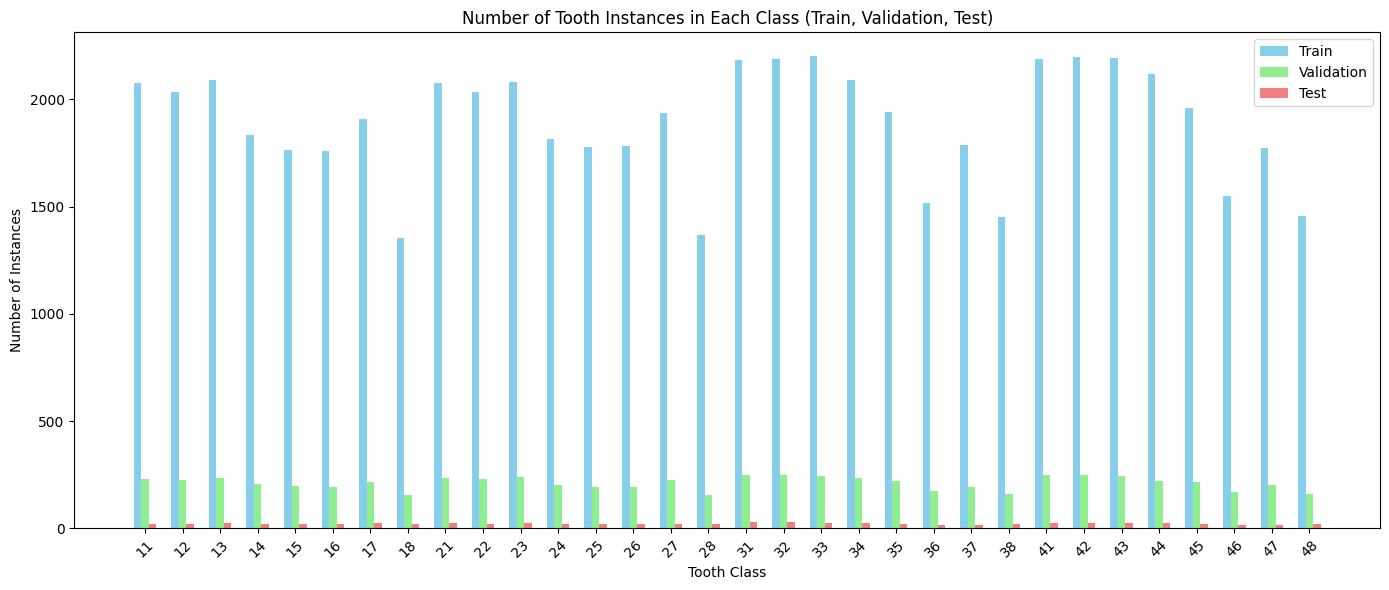

In [ ]:
data_dirs = {
    "Train": "/content/drive/MyDrive/teeth_detection_dataset/train/images",
    "Validation": "/content/drive/MyDrive/teeth_detection_dataset/valid/images",
    "Test": "/content/drive/MyDrive/teeth_detection_dataset/test/images"
}

class_names = ['11', '12', '13', '14', '15', '16', '17', '18', '21', '22', '23', '24', '25', '26', '27', '28',
               '31', '32', '33', '34', '35', '36', '37', '38', '41', '42', '43', '44', '45', '46', '47', '48']

def count_images_by_class(images_dir, labels_dir, class_names):
    class_counts = {cls: 0 for cls in class_names}

    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                class_name = class_names[class_id]
                class_counts[class_name] += 1

    return class_counts

image_counts = {}
for split, image_dir in data_dirs.items():
    label_dir = image_dir.replace("images", "labels")
    image_counts[split] = count_images_by_class(image_dir, label_dir, class_names)

x = np.arange(len(class_names))
width = 0.2
train_values = [image_counts["Train"].get(cls, 0) for cls in class_names]
valid_values = [image_counts["Validation"].get(cls, 0) for cls in class_names]
test_values = [image_counts["Test"].get(cls, 0) for cls in class_names]

plt.figure(figsize=(14, 6))
plt.bar(x - width, train_values, width, label='Train', color='skyblue')
plt.bar(x, valid_values, width, label='Validation', color='lightgreen')
plt.bar(x + width, test_values, width, label='Test', color='lightcoral')
plt.xlabel('Tooth Class')
plt.ylabel('Number of Instances')
plt.title('Number of Tooth Instances in Each Class (Train, Validation, Test)')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Distribution of Images Across Train, Validation, and Test Sets

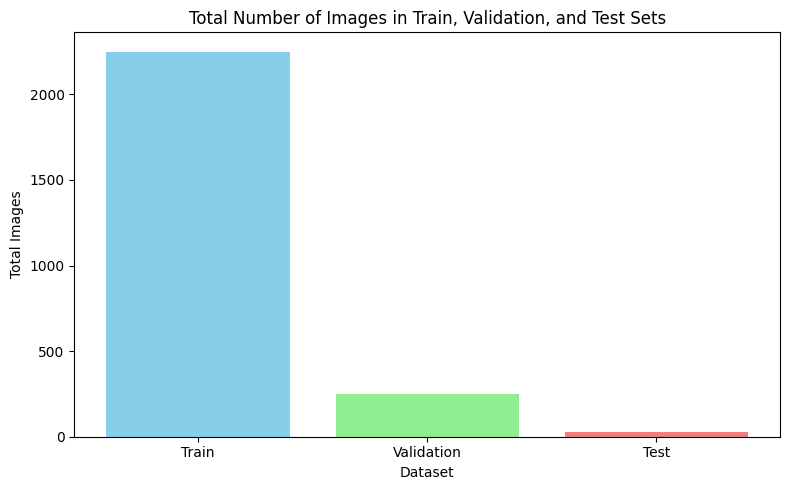

In [ ]:
def count_total_images(images_dir):
    return len([img for img in os.listdir(images_dir) if img.endswith(('.jpg', '.png'))])

total_counts = {split: count_total_images(image_dir) for split, image_dir in data_dirs.items()}

plt.figure(figsize=(8, 5))
plt.bar(total_counts.keys(), total_counts.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.xlabel('Dataset')
plt.ylabel('Total Images')
plt.title('Total Number of Images in Train, Validation, and Test Sets')
plt.tight_layout()
plt.show()

# Data Splitting for Balanced Train, Validation, and Test Sets

In [ ]:
base_dir = "/content/drive/MyDrive/teeth_detection_dataset"
data_dirs = {
    "train": {"images": os.path.join(base_dir, "train/images"), "labels": os.path.join(base_dir, "train/labels")},
    "valid": {"images": os.path.join(base_dir, "valid/images"), "labels": os.path.join(base_dir, "valid/labels")},
    "test": {"images": os.path.join(base_dir, "test/images"), "labels": os.path.join(base_dir, "test/labels")},
}

for split in data_dirs.values():
    os.makedirs(split["images"], exist_ok=True)
    os.makedirs(split["labels"], exist_ok=True)

train_images = [f for f in os.listdir(data_dirs["train"]["images"]) if f.endswith((".jpg", ".png"))]

random.seed(42)
random.shuffle(train_images)

total_images = len(train_images) + len(os.listdir(data_dirs["valid"]["images"])) + len(os.listdir(data_dirs["test"]["images"]))
train_target = int(total_images * 0.75)
valid_target = int(total_images * 0.15)
test_target = int(total_images * 0.1)

valid_needed = valid_target - len(os.listdir(data_dirs["valid"]["images"]))
test_needed = test_target - len(os.listdir(data_dirs["test"]["images"]))

valid_files = train_images[:valid_needed]
test_files = train_images[valid_needed:valid_needed + test_needed]

def move_files(file_list, src_dirs, dest_dirs):
    """Moves image and corresponding label file."""
    for file_name in file_list:
        src_img = os.path.join(src_dirs["images"], file_name)
        dest_img = os.path.join(dest_dirs["images"], file_name)

        label_file = file_name.replace(".jpg", ".txt").replace(".png", ".txt")
        src_lbl = os.path.join(src_dirs["labels"], label_file)
        dest_lbl = os.path.join(dest_dirs["labels"], label_file)

        if os.path.exists(src_img):
            shutil.move(src_img, dest_img)
        if os.path.exists(src_lbl):
            shutil.move(src_lbl, dest_lbl)

move_files(valid_files, data_dirs["train"], data_dirs["valid"])
move_files(test_files, data_dirs["train"], data_dirs["test"])

print(f"Final dataset distribution after balanced:")
print(f"Train: {len(os.listdir(data_dirs['train']['images']))} images")
print(f"Validation: {len(os.listdir(data_dirs['valid']['images']))} images")
print(f"Test: {len(os.listdir(data_dirs['test']['images']))} images")


Final dataset distribution after balanced:
Train: 1897 images
Validation: 379 images
Test: 252 images


# Distribution of Images Across Train, Validation, and Test Sets after balanced dataset

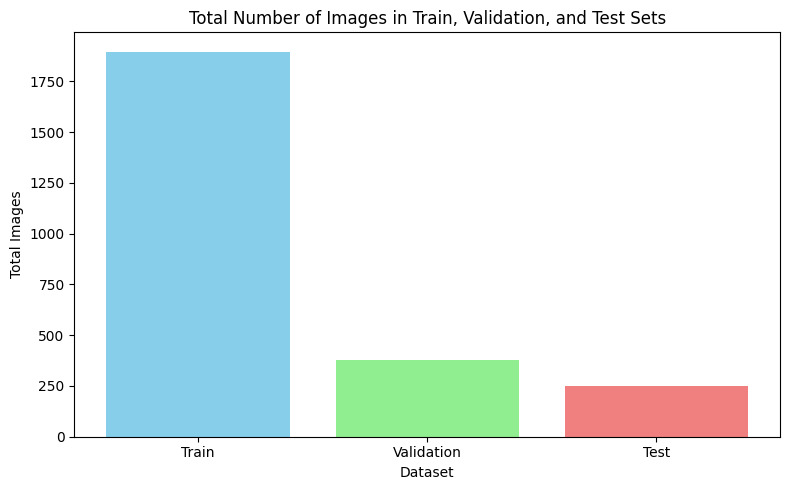

In [ ]:
data_dirs = {
    "Train": "/content/drive/MyDrive/teeth_detection_dataset/train/images",
    "Validation": "/content/drive/MyDrive/teeth_detection_dataset/valid/images",
    "Test": "/content/drive/MyDrive/teeth_detection_dataset/test/images"
}
def count_total_images(images_dir):
    return len([img for img in os.listdir(images_dir) if img.endswith(('.jpg', '.png'))])

total_counts = {split: count_total_images(image_dir) for split, image_dir in data_dirs.items()}

plt.figure(figsize=(8, 5))
plt.bar(total_counts.keys(), total_counts.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.xlabel('Dataset')
plt.ylabel('Total Images')
plt.title('Total Number of Images in Train, Validation, and Test Sets')
plt.tight_layout()
plt.show()

# Preprocessing and Augmentation Pipeline

In [ ]:
datasets = {
    "train": "/content/drive/MyDrive/teeth_detection_dataset/train/",
    "valid": "/content/drive/MyDrive/teeth_detection_dataset/valid/",
    "test": "/content/drive/MyDrive/teeth_detection_dataset/test/"
}

output_root = "/content/drive/MyDrive/data_after_agu/"

train_augmentations = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.3, p=0.5),
    A.GaussNoise(var_limit=(0.1,0.2), p=0.5)
])


resize_transform = A.Compose([
    A.Resize(640, 640),
])

def process_image(image_path, apply_augmentation=False):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if apply_augmentation:
        image = train_augmentations(image=image)["image"]


    image = resize_transform(image=image)["image"]

    return (image * 255).astype(np.uint8)

for split, dataset_path in datasets.items():
    image_folder = os.path.join(dataset_path, "images/")
    label_folder = os.path.join(dataset_path, "labels/")

    output_image_folder = os.path.join(output_root, split, "images/")
    output_label_folder = os.path.join(output_root, split, "labels/")

    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_label_folder, exist_ok=True)

    for img_path in glob(os.path.join(image_folder, "*.jpg")):
        apply_augmentation = True if split == "train" else False
        processed_image = process_image(img_path, apply_augmentation)


        output_file = os.path.join(output_image_folder, os.path.basename(img_path))
        cv2.imwrite(output_file, processed_image)

        label_path = os.path.join(label_folder, os.path.basename(img_path).replace(".jpg", ".txt"))
        if os.path.exists(label_path):
            output_label_path = os.path.join(output_label_folder, os.path.basename(label_path))
            os.system(f"cp {label_path} {output_label_path}")

    print(f"Processed {split} dataset and saved in {output_image_folder}")

print("All datasets are preprocessed and saved successfully")


Processed train dataset and saved in /content/drive/MyDrive/data_after_agu/train/images/
Processed valid dataset and saved in /content/drive/MyDrive/data_after_agu/valid/images/
Processed test dataset and saved in /content/drive/MyDrive/data_after_agu/test/images/
All datasets are preprocessed and saved successfully


# Visualization of Annotated Teeth Detection Dataset

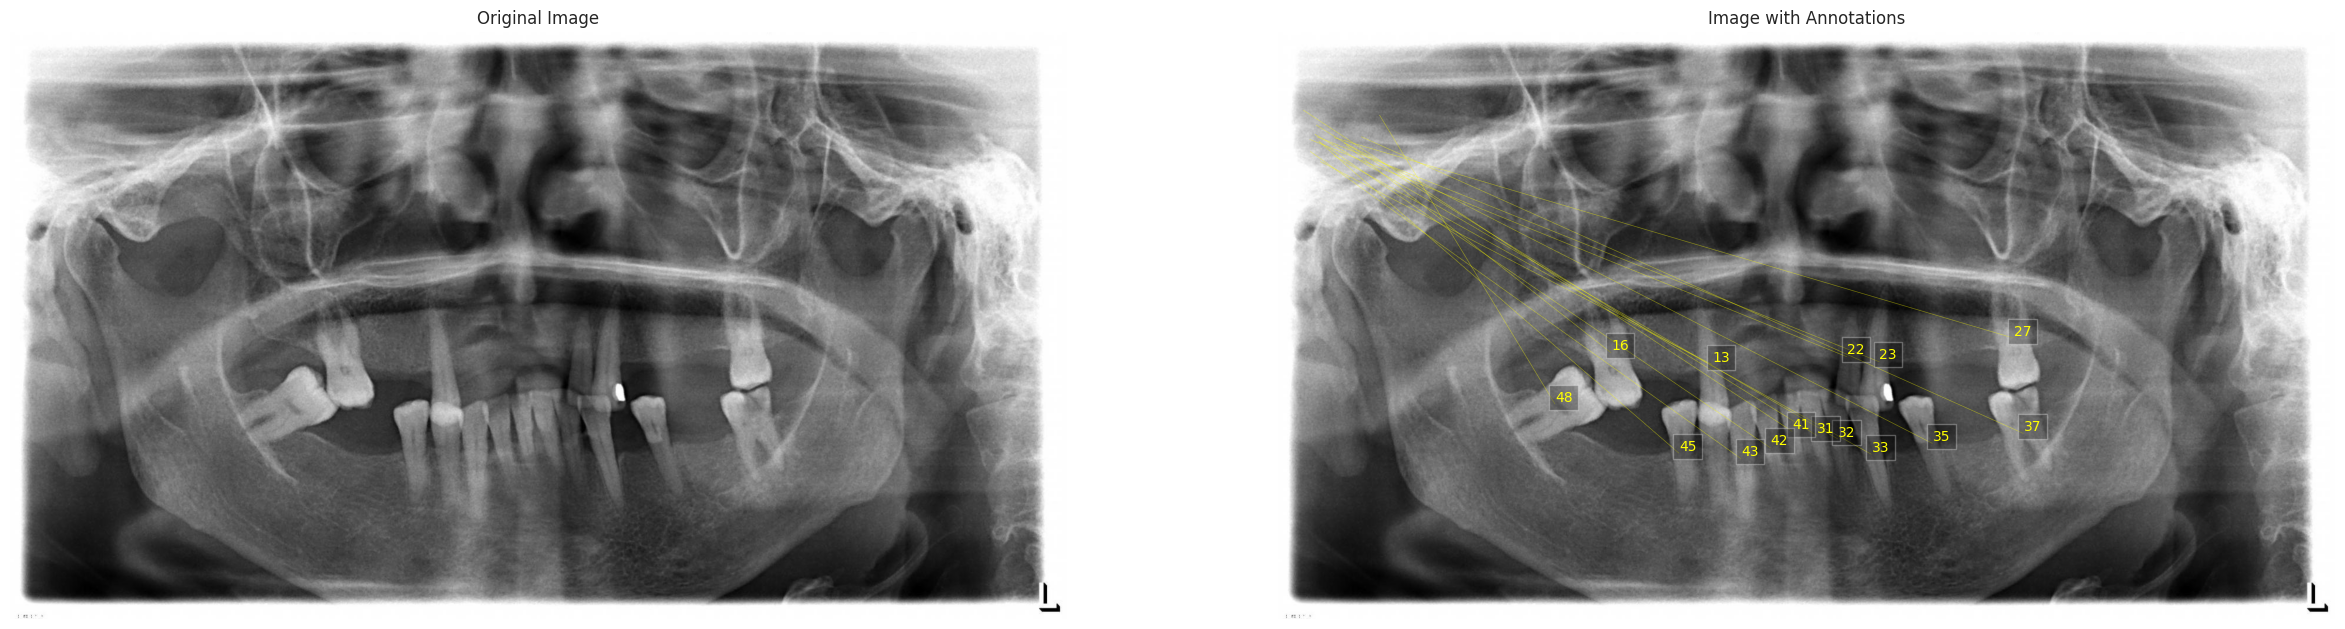

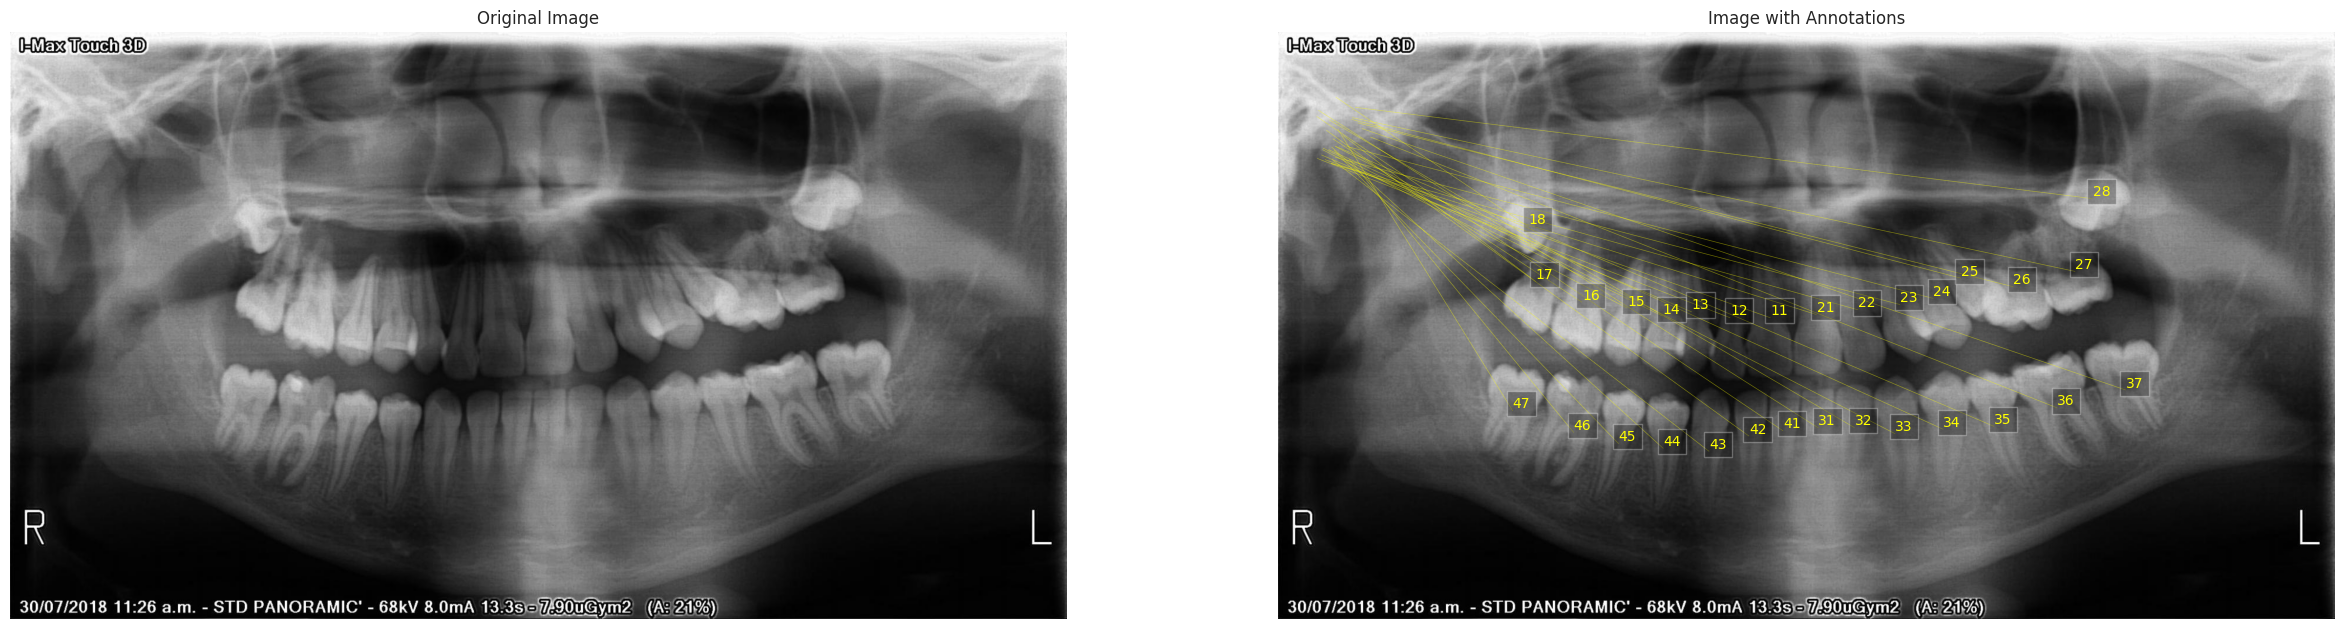

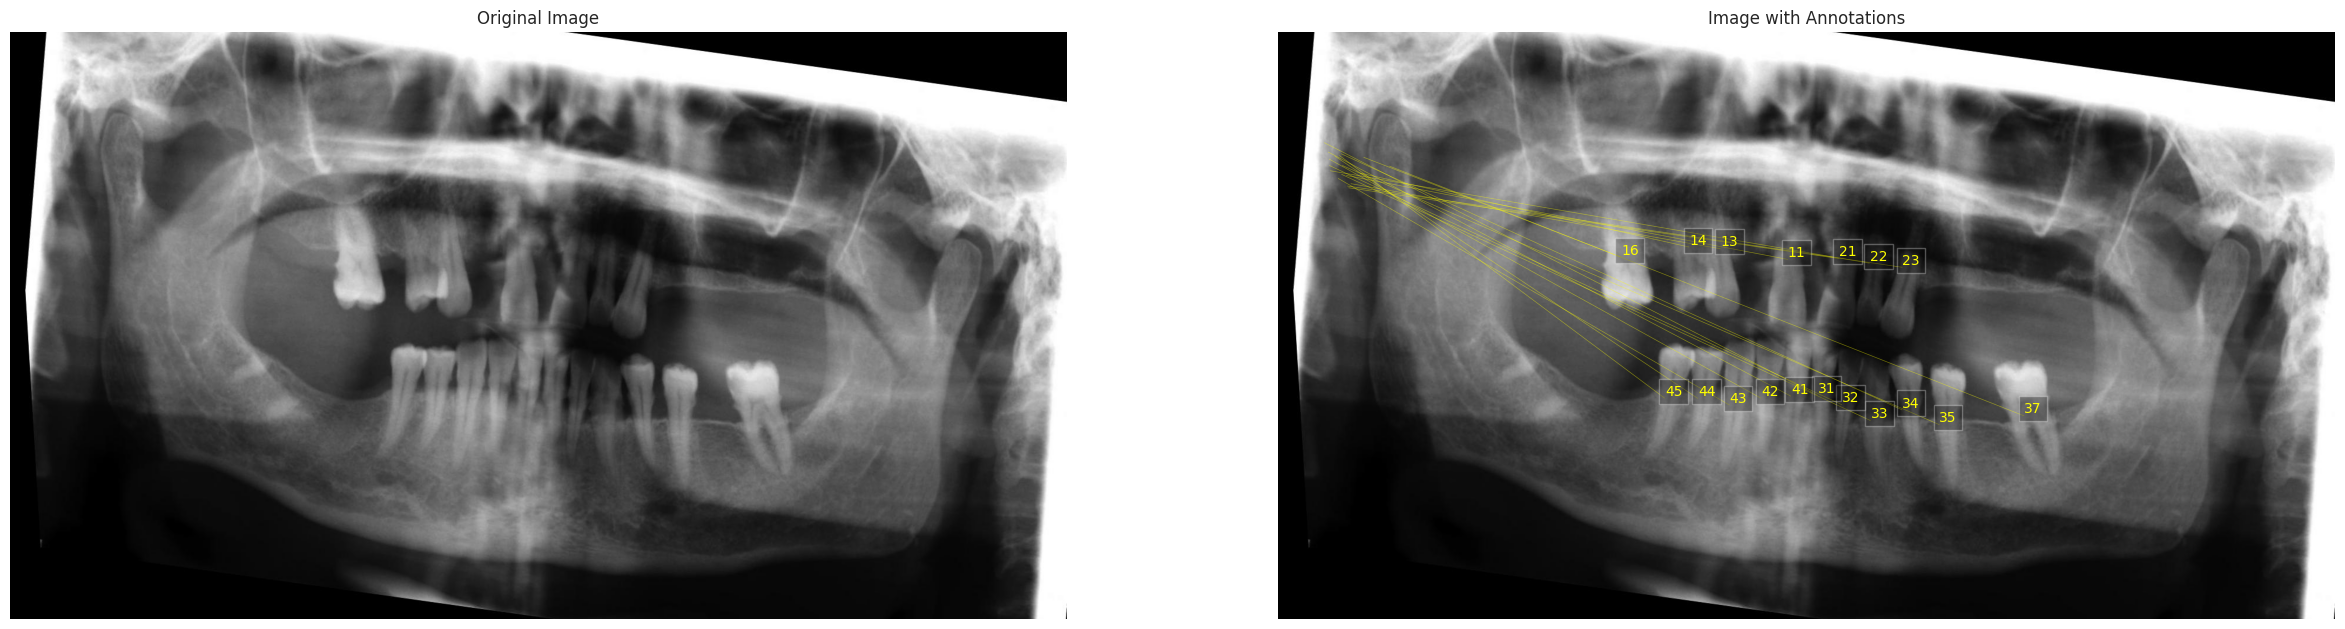

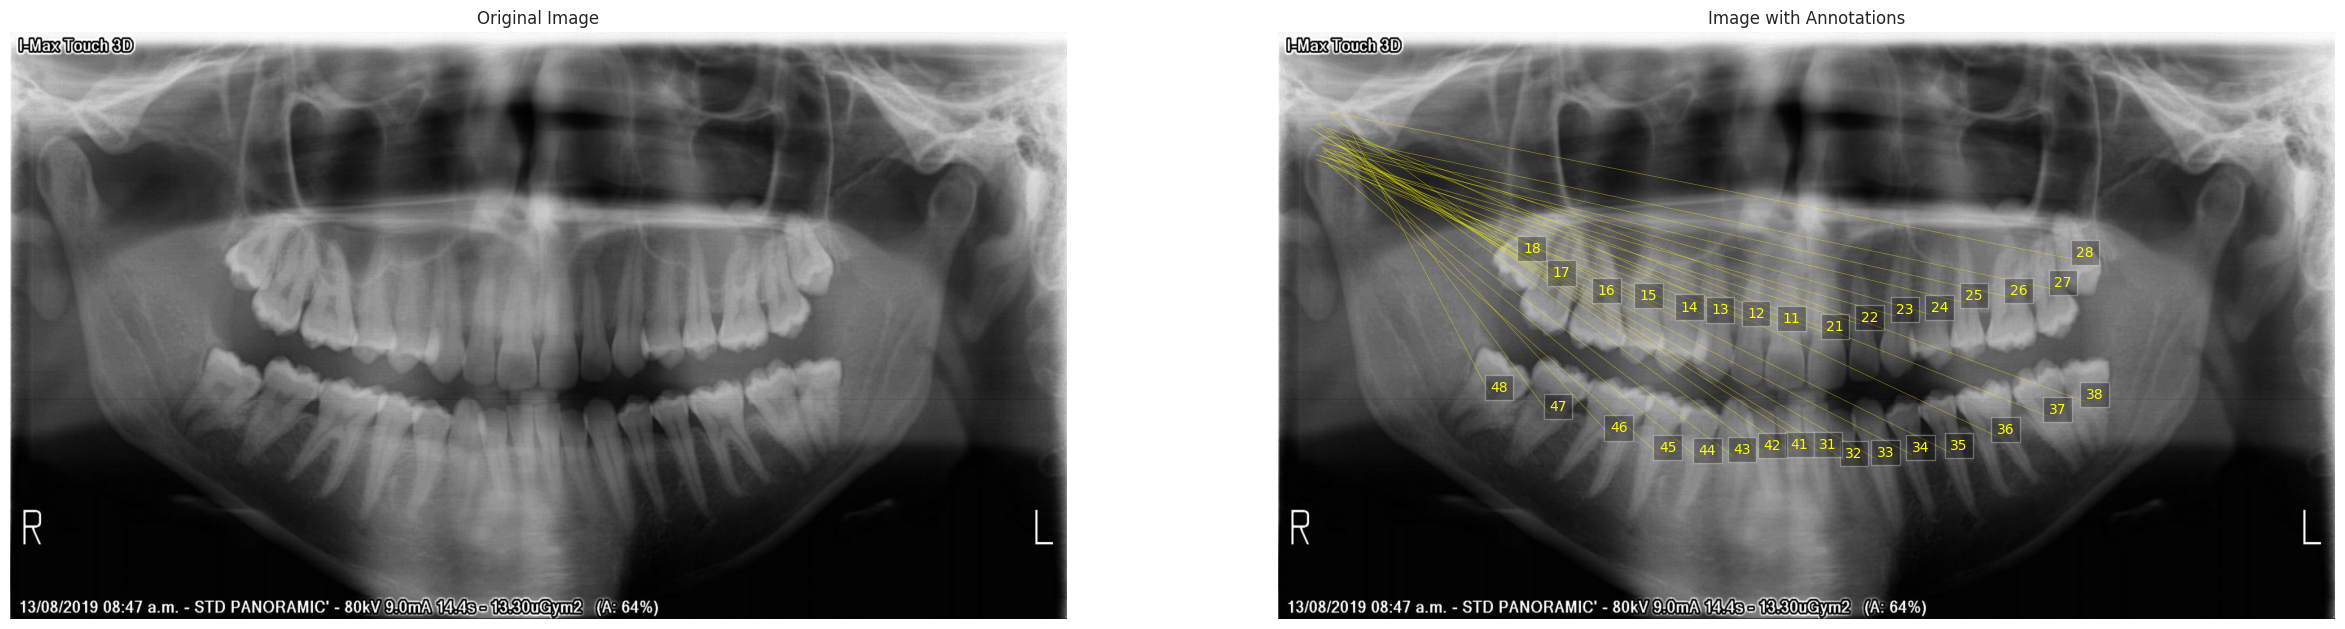

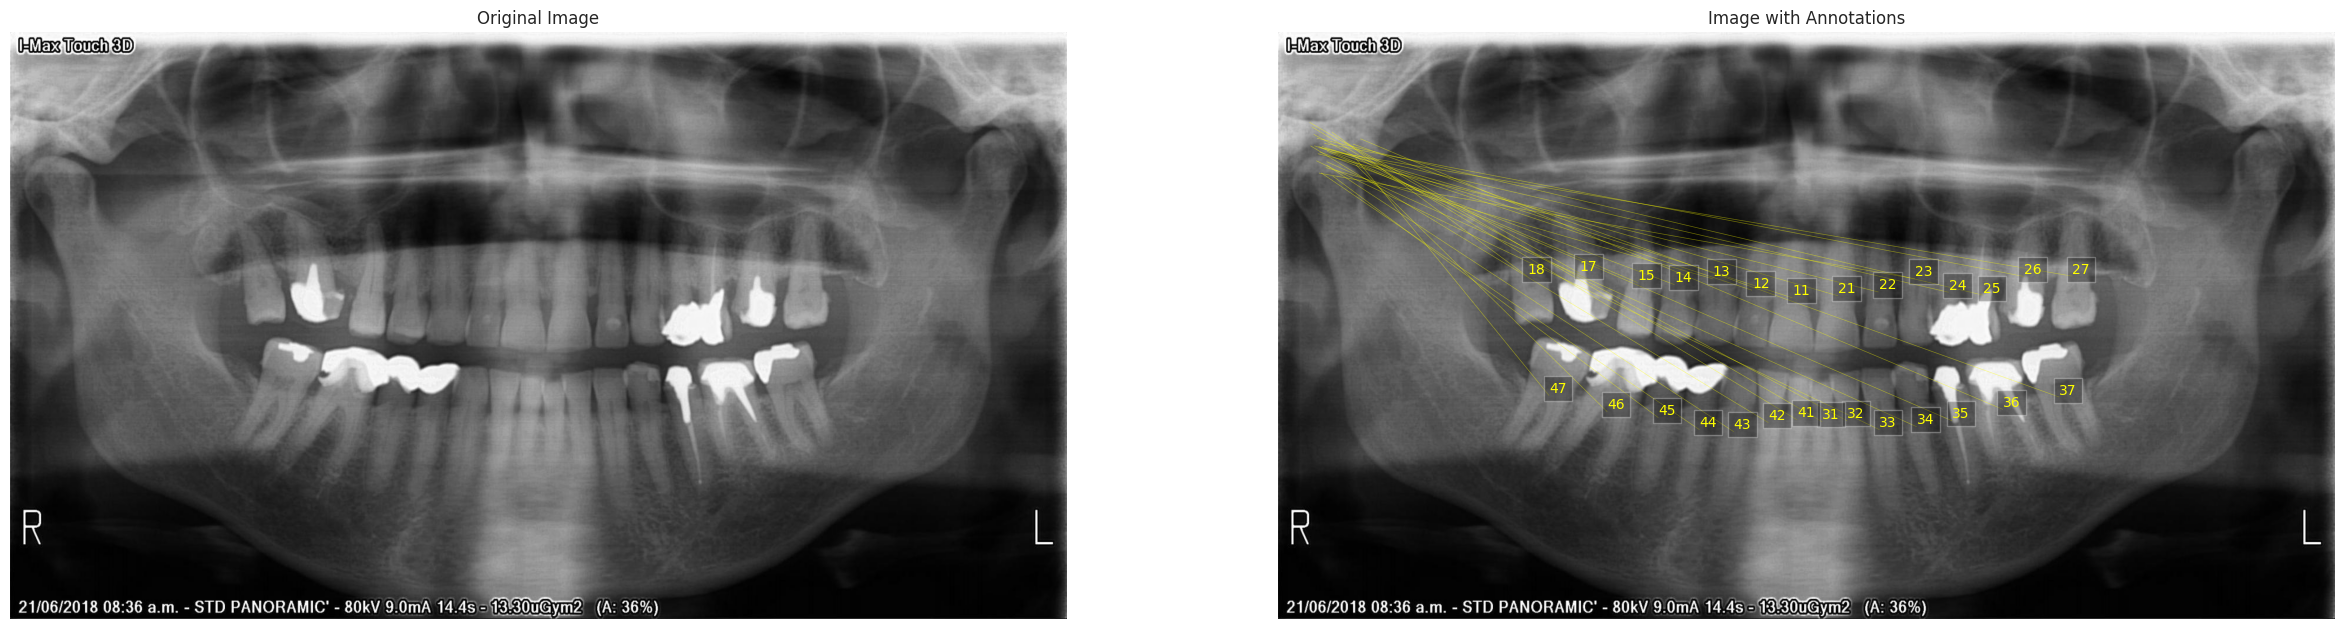

In [19]:
classes_names =['11', '12', '13', '14', '15', '16', '17', '18', '21', '22', '23', '24', '25', '26', '27', '28',
                '31', '32', '33', '34', '35', '36', '37', '38', '41', '42', '43', '44', '45', '46', '47', '48']

def load_labels(label_path):
    with open(label_path, 'r') as label_file:
        label_lines = label_file.read().strip().split('\n')
        return [list(map(float, line.split())) for line in label_lines]

def plot_labels(ax, labels_data, img_w, img_h, color, classes):
    for label in labels_data:
        if len(label) < 2:
            continue

        class_id = int(label[0])
        points = label[1:]
        class_name = classes[class_id].upper()

        polygon_points = [(points[i] * img_w, points[i + 1] * img_h) for i in range(0, len(points) - 1, 2)]
        polygon = Polygon(polygon_points, closed=True, edgecolor=color, facecolor='lightblue', linewidth=0.5, alpha=0.4)
        ax.add_patch(polygon)

        x_min, y_min = polygon_points[0]
        ax.text(x_min, y_min - 5, class_name, color=color, fontsize=10, bbox=dict(facecolor='black', alpha=0.3))

def display_images(dataset_path, sample_size=5):
    dataset_path = Path(dataset_path)
    valid_path = dataset_path / 'valid'
    labels_dir = valid_path / 'labels'
    images_dir = valid_path / 'images'

    if not labels_dir.exists() or not images_dir.exists():
        print(f"Labels or images folder not found in {valid_path}")
        return

    image_files = list(images_dir.iterdir())
    if not image_files:
        print(f"No images found in {images_dir}")
        return

    random_sample = random.sample(image_files, min(sample_size, len(image_files)))

    for image_file in random_sample:
        image = cv2.imread(str(image_file.absolute()))
        if image is None:
            print(f"Failed to load image: {image_file}")
            continue

        label_files = list(labels_dir.glob(f'{image_file.stem}.*'))
        if not label_files:
            print(f"No label file found for image: {image_file}")
            continue

        labels_path = label_files[0]
        labels_data = load_labels(labels_path)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        fig, ax = plt.subplots(1, 2, figsize=(30, 12))
        ax[0].imshow(image_rgb)
        ax[0].set_title("Original Image")
        ax[1].imshow(image_rgb)
        ax[1].set_title("Image with Annotations")

        img_h, img_w = image.shape[:2]
        plot_labels(ax[1], labels_data, img_w, img_h, 'yellow', classes_names)

        for a in ax:
            a.axis('off')
        plt.show()

display_images('/content/drive/MyDrive/teeth_detection_dataset', sample_size=5)


# YOLOv8 Model Initialization

In [5]:
#!pip install ultralytics
from IPython.display import clear_output
clear_output()
import sys
sys.path.append('/content/drive/MyDrive/packages/')
from ultralytics import YOLO
model = YOLO('yolov8s.pt')

# Hyperparameters for YOLOv8 Training

In [6]:
base_model = 'yolov8s.pt'
BATCH_SIZE = 30
EPOCHS = 60
IMG_SIZE = 640
data_yaml = '/content/drive/MyDrive/data_after_agu/data.yaml'

# Fine-Tuning YOLOv8 on Teeth Detection Data

In [7]:
model.train(data=data_yaml,
  epochs=EPOCHS,
  imgsz=IMG_SIZE,
  batch=BATCH_SIZE)

New https://pypi.org/project/ultralytics/8.3.97 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/data_after_agu/data.yaml, epochs=60, time=None, patience=100, batch=30, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

train: Scanning /content/drive/MyDrive/data_after_agu/train/labels.cache... 1897 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1897/1897 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 192, len(boxes) = 51027. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/data_after_agu/valid/labels.cache... 379 images, 0 backgrounds, 0 corrupt: 100%|██████████| 379/379 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 31, len(boxes) = 10172. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000278, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      9.97G      2.248      3.768      1.817        373        640: 100%|██████████| 64/64 [12:41<00:00, 11.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


                   all        379      10172      0.211      0.655      0.261      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      8.19G       1.69       1.79      1.397        195        640: 100%|██████████| 64/64 [00:49<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


                   all        379      10172      0.381      0.767      0.443      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      9.76G      1.629      1.542      1.369        266        640: 100%|██████████| 64/64 [00:48<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


                   all        379      10172       0.43      0.786      0.499      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      10.7G      1.569      1.409      1.338        308        640: 100%|██████████| 64/64 [00:46<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


                   all        379      10172      0.568      0.787      0.686      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60       9.1G      1.533      1.301      1.313        293        640: 100%|██████████| 64/64 [00:47<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        379      10172      0.597       0.79      0.718       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      8.39G      1.482      1.194      1.284        274        640: 100%|██████████| 64/64 [00:46<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]


                   all        379      10172      0.484      0.798      0.587      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      9.63G      1.449       1.09       1.27        344        640: 100%|██████████| 64/64 [00:45<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


                   all        379      10172      0.704      0.823      0.816       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60       8.7G      1.424      1.033      1.263        349        640: 100%|██████████| 64/64 [00:46<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]

                   all        379      10172      0.809      0.852      0.899      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60       9.6G      1.398     0.9705      1.246        213        640: 100%|██████████| 64/64 [00:46<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]

                   all        379      10172      0.769      0.827      0.869      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      10.1G      1.381     0.9347      1.245        211        640: 100%|██████████| 64/64 [00:46<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


                   all        379      10172      0.807      0.853      0.897      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      10.4G      1.372     0.9055      1.238        295        640: 100%|██████████| 64/64 [00:46<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


                   all        379      10172      0.693      0.825      0.797      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      8.12G      1.345     0.8742      1.231        314        640: 100%|██████████| 64/64 [00:46<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]

                   all        379      10172      0.864       0.89      0.937      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      8.08G      1.315     0.8301      1.214        257        640: 100%|██████████| 64/64 [00:47<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


                   all        379      10172      0.871      0.888      0.932      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      9.07G      1.325     0.8321      1.227        226        640: 100%|██████████| 64/64 [00:47<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

                   all        379      10172      0.806      0.852      0.907      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      9.99G        1.3     0.7977      1.211        124        640: 100%|██████████| 64/64 [00:46<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]


                   all        379      10172      0.864      0.882      0.945      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      8.11G      1.315     0.7779      1.209        277        640: 100%|██████████| 64/64 [00:46<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]

                   all        379      10172      0.865      0.887      0.936      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      9.07G      1.285     0.7764      1.202        309        640: 100%|██████████| 64/64 [00:52<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


                   all        379      10172      0.843      0.861      0.928      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      9.05G      1.276     0.7544      1.203        232        640: 100%|██████████| 64/64 [00:46<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

                   all        379      10172      0.802      0.843      0.898       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      8.15G      1.263      0.747      1.194        277        640: 100%|██████████| 64/64 [00:47<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


                   all        379      10172      0.918      0.922      0.963      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      8.36G       1.26     0.7438      1.192        301        640: 100%|██████████| 64/64 [00:46<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


                   all        379      10172      0.751       0.83      0.861      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      8.95G      1.251     0.7252      1.192        245        640: 100%|██████████| 64/64 [00:45<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]

                   all        379      10172      0.874      0.885      0.939      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      10.1G      1.222     0.6948      1.177        245        640: 100%|██████████| 64/64 [00:48<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]

                   all        379      10172      0.874      0.887      0.934       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      9.08G      1.233     0.6998      1.181        347        640: 100%|██████████| 64/64 [00:48<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        379      10172      0.918      0.911      0.962      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      9.11G      1.227     0.6832       1.18        211        640: 100%|██████████| 64/64 [00:46<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


                   all        379      10172      0.865      0.881      0.918      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60       7.7G      1.222     0.6698      1.182        264        640: 100%|██████████| 64/64 [00:47<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]

                   all        379      10172      0.892      0.907      0.947      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      8.99G      1.209     0.6645      1.174        248        640: 100%|██████████| 64/64 [00:45<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]

                   all        379      10172      0.838      0.847      0.907      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      8.05G      1.204     0.6503      1.166        264        640: 100%|██████████| 64/64 [00:48<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]

                   all        379      10172      0.858      0.871      0.916      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      9.51G      1.204     0.6567      1.173        317        640: 100%|██████████| 64/64 [00:46<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]

                   all        379      10172      0.887       0.89      0.939      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      8.03G      1.178     0.6462      1.157        355        640: 100%|██████████| 64/64 [00:47<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        379      10172      0.887       0.89      0.943      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      8.64G      1.181     0.6396      1.157        495        640: 100%|██████████| 64/64 [00:45<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]

                   all        379      10172      0.892      0.898      0.945      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      8.13G      1.167     0.6336      1.152        276        640: 100%|██████████| 64/64 [00:45<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


                   all        379      10172      0.884      0.882      0.936      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      8.06G      1.166     0.6239      1.154        205        640: 100%|██████████| 64/64 [00:46<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]

                   all        379      10172      0.893       0.89      0.939      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      9.41G       1.15     0.6126      1.143        351        640: 100%|██████████| 64/64 [00:47<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]

                   all        379      10172      0.913      0.919       0.96      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      7.68G      1.155     0.6112      1.146        220        640: 100%|██████████| 64/64 [00:48<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]

                   all        379      10172      0.894       0.88      0.933      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      9.73G      1.151     0.6078      1.142        305        640: 100%|██████████| 64/64 [00:47<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]

                   all        379      10172       0.91      0.912      0.958      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      8.23G      1.145     0.6074      1.141        189        640: 100%|██████████| 64/64 [00:47<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        379      10172      0.942      0.941      0.971      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      9.16G      1.132     0.5885      1.131        345        640: 100%|██████████| 64/64 [00:45<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        379      10172      0.921       0.93      0.965      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      9.38G      1.134     0.5957      1.136        186        640: 100%|██████████| 64/64 [00:46<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


                   all        379      10172      0.928      0.922      0.966      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      8.98G      1.122     0.5844      1.126        362        640: 100%|██████████| 64/64 [00:45<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        379      10172      0.939      0.938      0.971      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      9.57G      1.121     0.5824       1.13        282        640: 100%|██████████| 64/64 [00:45<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]

                   all        379      10172      0.889      0.905      0.939      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      9.48G      1.109     0.5729      1.123        278        640: 100%|██████████| 64/64 [00:47<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]

                   all        379      10172      0.892      0.895      0.935      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      8.67G      1.099     0.5639      1.115        221        640: 100%|██████████| 64/64 [00:46<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        379      10172      0.898      0.907      0.947      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      9.28G      1.102     0.5726      1.119        318        640: 100%|██████████| 64/64 [00:46<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]

                   all        379      10172      0.907      0.915      0.951      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      8.22G      1.098     0.5674      1.116        290        640: 100%|██████████| 64/64 [00:48<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        379      10172      0.904      0.903      0.946      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      8.54G      1.089     0.5617      1.112        307        640: 100%|██████████| 64/64 [00:45<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        379      10172      0.922      0.918      0.962      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      9.95G      1.085      0.557      1.112        347        640: 100%|██████████| 64/64 [00:47<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        379      10172      0.919      0.919      0.958      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      8.16G      1.079      0.554      1.109        306        640: 100%|██████████| 64/64 [00:49<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]

                   all        379      10172      0.912      0.908      0.956      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      9.53G      1.074     0.5481      1.105        206        640: 100%|██████████| 64/64 [00:47<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]

                   all        379      10172        0.9      0.913       0.95      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      8.51G      1.072     0.5403      1.103        295        640: 100%|██████████| 64/64 [00:46<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


                   all        379      10172      0.932      0.927      0.967      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      8.16G      1.076     0.5412      1.104        299        640: 100%|██████████| 64/64 [00:46<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]

                   all        379      10172      0.906      0.906       0.95      0.633


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      7.12G      1.083     0.4967      1.151        192        640: 100%|██████████| 64/64 [00:46<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]

                   all        379      10172      0.926      0.921      0.959      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      7.11G      1.049     0.4758       1.13        202        640: 100%|██████████| 64/64 [00:42<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

                   all        379      10172      0.884      0.886      0.928      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      7.12G      1.043     0.4807       1.13        175        640: 100%|██████████| 64/64 [00:42<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


                   all        379      10172      0.915      0.913      0.953       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      7.11G      1.044     0.4673      1.128        202        640: 100%|██████████| 64/64 [00:42<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]

                   all        379      10172      0.931      0.925      0.961      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      7.11G      1.037     0.4624      1.126        191        640: 100%|██████████| 64/64 [00:42<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]

                   all        379      10172      0.938      0.934      0.966      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      7.12G      1.035     0.4603      1.126        204        640: 100%|██████████| 64/64 [00:42<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


                   all        379      10172      0.937      0.928      0.962      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      7.12G      1.019     0.4547      1.116        168        640: 100%|██████████| 64/64 [00:43<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]

                   all        379      10172      0.928      0.926      0.961      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      7.11G      1.017     0.4501      1.116        200        640: 100%|██████████| 64/64 [00:42<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]

                   all        379      10172       0.93      0.927      0.962      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      7.12G      1.013     0.4534      1.117        195        640: 100%|██████████| 64/64 [00:42<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]

                   all        379      10172      0.923      0.924      0.956       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      7.13G     0.9986     0.4466      1.106        179        640: 100%|██████████| 64/64 [00:42<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        379      10172      0.927      0.925      0.959      0.628



60 epochs completed in 1.106 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 22.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,137,968 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]


                   all        379      10172      0.932      0.927      0.967      0.644
                    11        352        352       0.96       0.95      0.982      0.664
                    12        340        340      0.967      0.946      0.981      0.626
                    13        352        352      0.945       0.92      0.972       0.62
                    14        305        305      0.934      0.875      0.962      0.606
                    15        299        299      0.928       0.89      0.956      0.622
                    16        294        294       0.94      0.904      0.964      0.679
                    17        322        322      0.931      0.877      0.958      0.666
                    18        239        239      0.918      0.838      0.947      0.647
                    21        354        354      0.958      0.966      0.988      0.664
                    22        346        346      0.942      0.965      0.977      0.621
                    2

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f1c18e98a50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,

# YOLOv8 Model Evaluation

In [8]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,137,968 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/data_after_agu/valid/labels.cache... 379 images, 0 backgrounds, 0 corrupt: 100%|██████████| 379/379 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 31, len(boxes) = 10172. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


                   all        379      10172      0.932      0.927      0.967      0.644
                    11        352        352       0.96       0.95      0.982      0.665
                    12        340        340      0.967      0.946      0.981      0.628
                    13        352        352      0.947      0.921      0.972      0.623
                    14        305        305      0.934      0.875      0.962      0.605
                    15        299        299      0.928       0.89      0.956      0.623
                    16        294        294       0.94      0.903      0.965      0.676
                    17        322        322      0.931      0.878      0.957      0.667
                    18        239        239      0.918      0.838      0.947      0.646
                    21        354        354      0.957      0.966      0.988      0.665
                    22        346        346      0.942      0.965      0.977      0.621
                    2

# YOLOv8 Inference: Object Detection on a Sample Image


image 1/1 /content/drive/MyDrive/data_after_agu/test/images/213_jpg.rf.bf23d182f18ddc8b486e4619ca36532d.jpg: 640x640 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 21, 1 22, 1 23, 1 24, 1 26, 1 27, 1 28, 1 31, 1 32, 1 33, 1 34, 1 35, 1 38, 1 41, 1 42, 1 43, 1 44, 1 45, 1 48, 16.5ms
Speed: 2.8ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train26
1 label saved to runs/detect/train26/labels


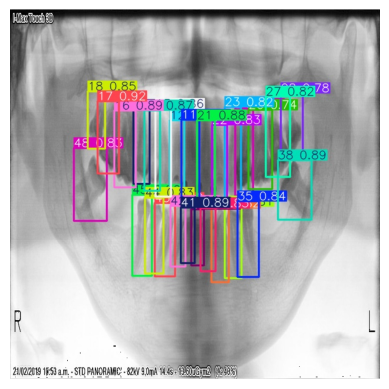

In [13]:
results = model.predict(
    source='/content/drive/MyDrive/data_after_agu/test/images/213_jpg.rf.bf23d182f18ddc8b486e4619ca36532d.jpg',
    conf=0.5,
    iou=0.45,
    save=True,
    save_txt=True,

)

output_image_path = '/content/runs/detect/train25/213_jpg.rf.bf23d182f18ddc8b486e4619ca36532d.jpg'
img = Image.open(output_image_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# Performance Metrics Visualization

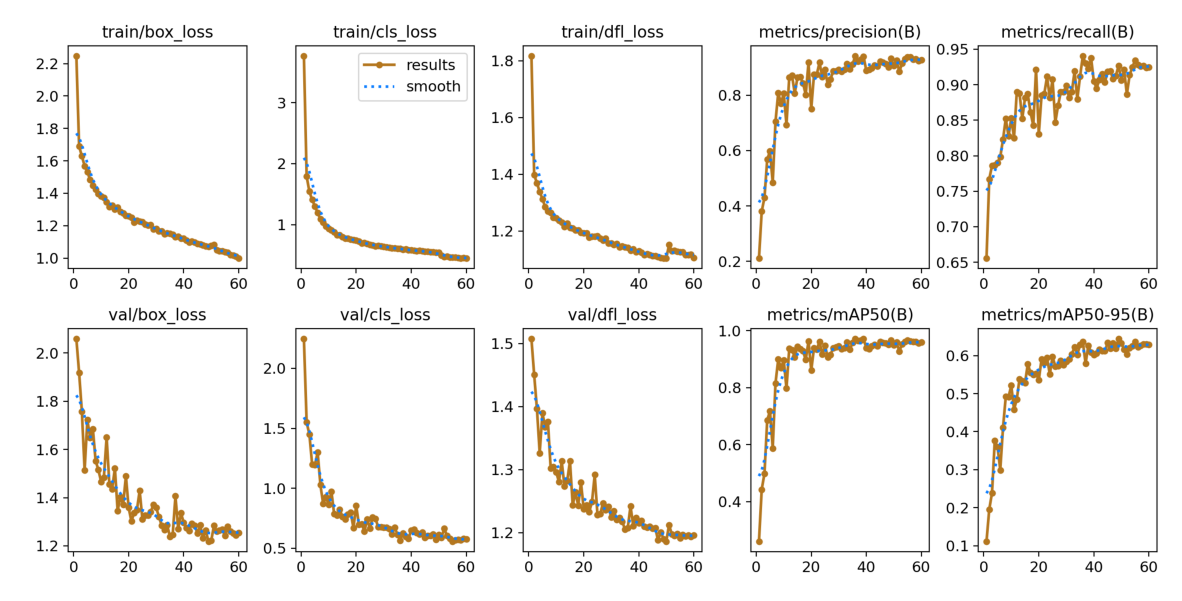

In [14]:
path = '/content/runs/detect/train2/results.png'

confusion_matrix = cv2.imread(path)
plt.figure(figsize=(15, 15))
plt.imshow(confusion_matrix)
plt.axis('off')
plt.show()



# Training Performance Metrics: Precision, Recall & mAP Over Epochs

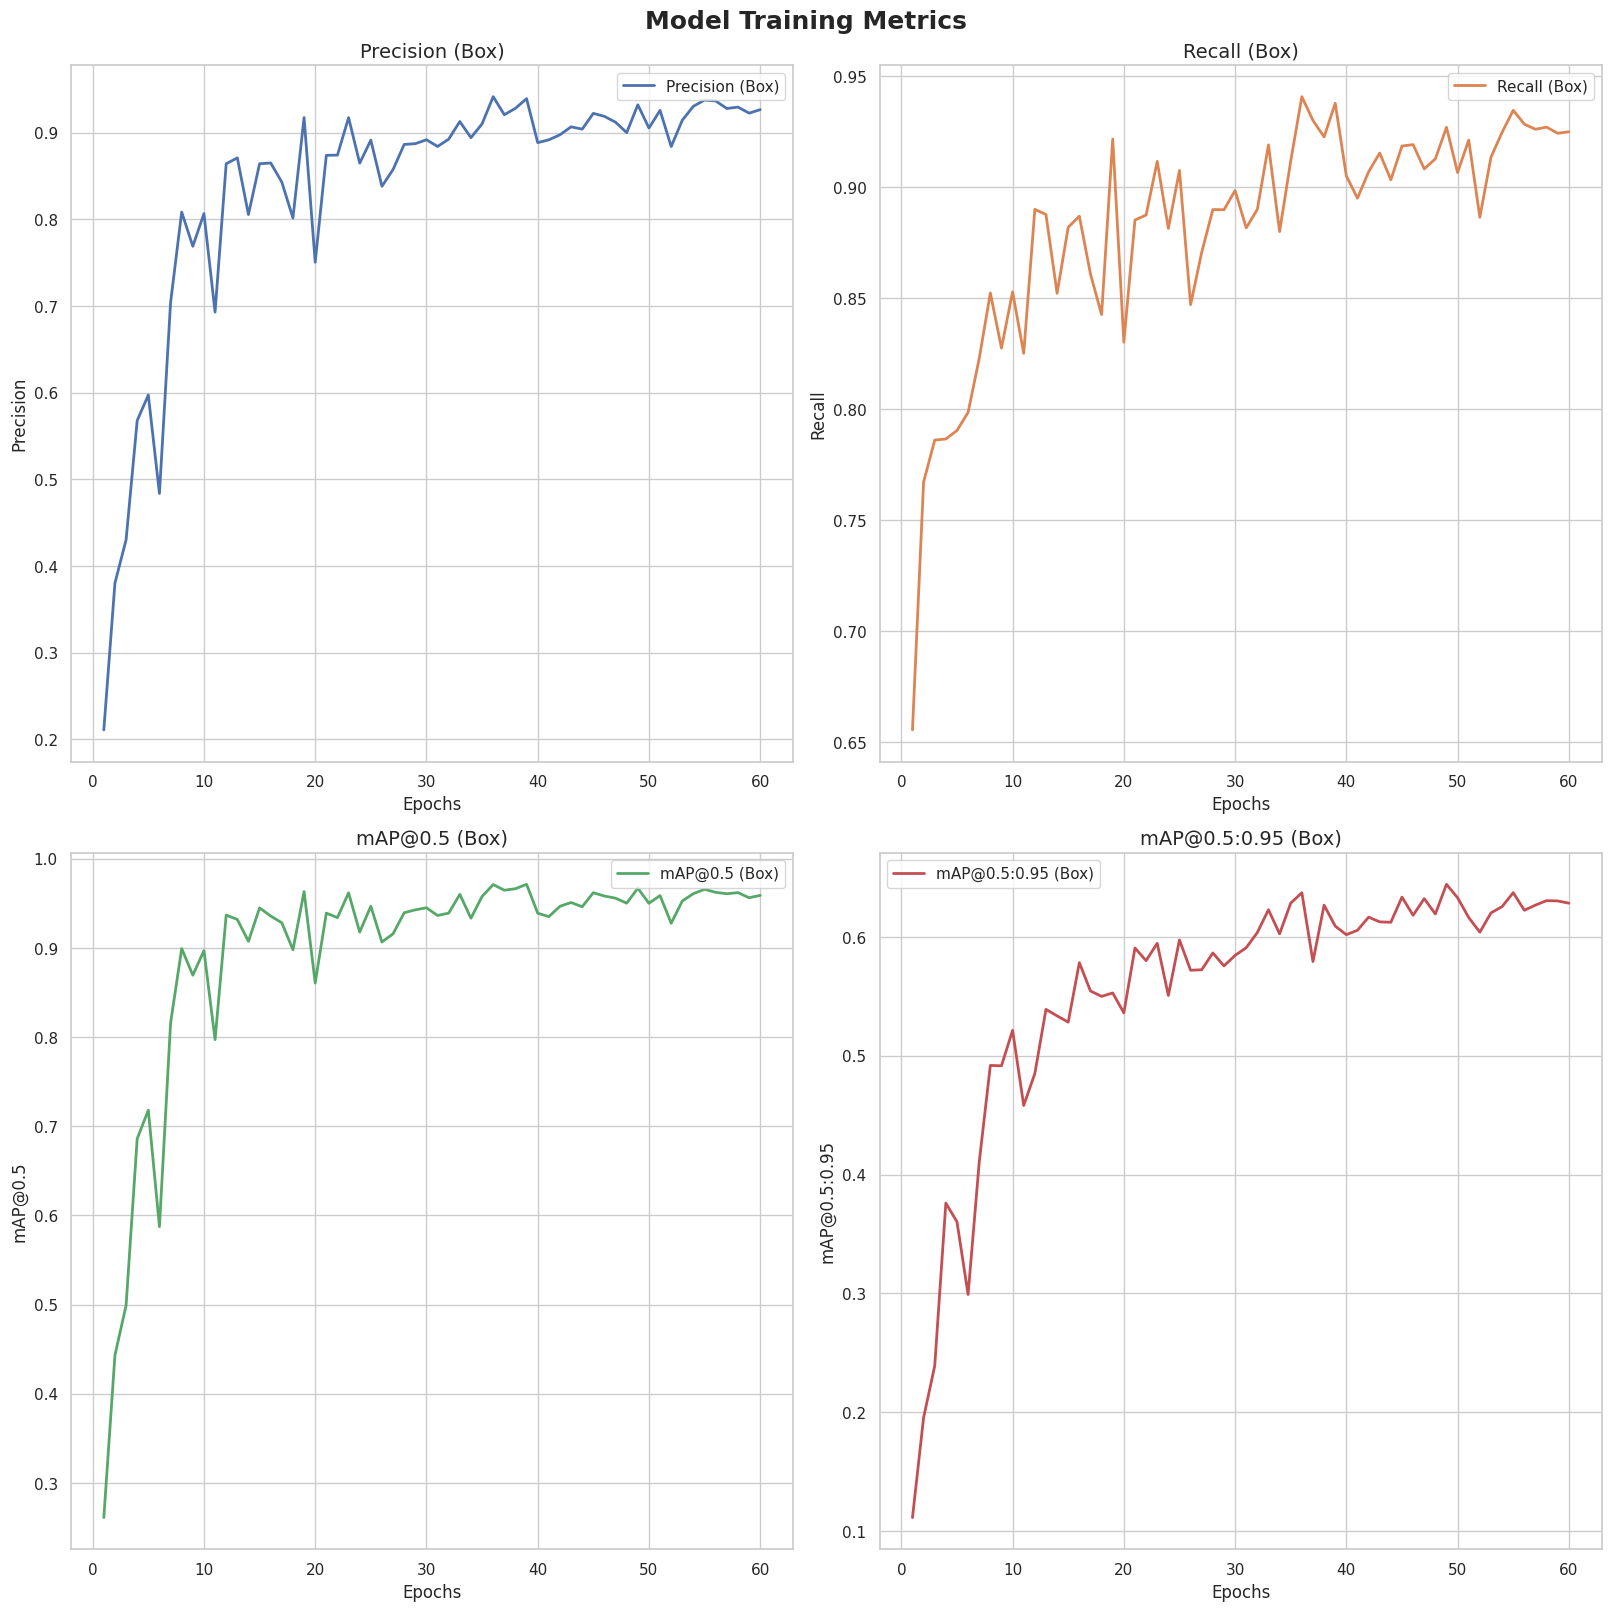

In [15]:
def visualize_metrics(file_path, train=True):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.strip()


    sns.set_theme(style="whitegrid")

    metrics = {
        "Precision (Box)": "metrics/precision(B)",
        "Recall (Box)": "metrics/recall(B)",
        "mAP@0.5 (Box)": "metrics/mAP50(B)",
        "mAP@0.5:0.95 (Box)": "metrics/mAP50-95(B)",

    }

    fig, axes = plt.subplots(2, 2, figsize=(16, 16), constrained_layout=True)
    fig.suptitle("Model Training Metrics", fontsize=18, fontweight="bold")

    for idx, (metric_name, column) in enumerate(metrics.items()):
        if column in data.columns:
            ax = axes[idx // 2, idx % 2]
            ax.plot(data['epoch'], data[column], label=metric_name, color=sns.color_palette()[idx % len(sns.color_palette())], linewidth=2)
            ax.set_title(metric_name, fontsize=14)
            ax.set_xlabel("Epochs", fontsize=12)
            ax.set_ylabel(metric_name.split()[0], fontsize=12)
            ax.legend()

    plt.show()

visualize_metrics("/content/runs/detect/train2/results.csv")


# Saving Trained YOLOv8 Model

In [17]:
source = "runs/detect/train2/weights/best.pt"
destination = "/content/drive/MyDrive/saved_models_after_agu/best.pt"

shutil.copy(source, destination)
print(f"File copied to: {destination}")


File copied to: /content/drive/MyDrive/saved_models_after_agu/best.pt


# Load Trained Model and Predict on Test Image


image 1/1 /content/drive/MyDrive/data_after_agu/test/images/213_jpg.rf.bf23d182f18ddc8b486e4619ca36532d.jpg: 640x640 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 21, 1 22, 1 23, 1 24, 1 26, 1 27, 1 28, 1 31, 1 32, 1 33, 1 34, 1 35, 1 38, 1 41, 1 42, 1 43, 1 44, 1 45, 1 48, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

Total number of teeth: 27 teeth
        8 incisors
        4 canines
        7 premolars
        8 molars

Total number of missing teeth: 5 teeth



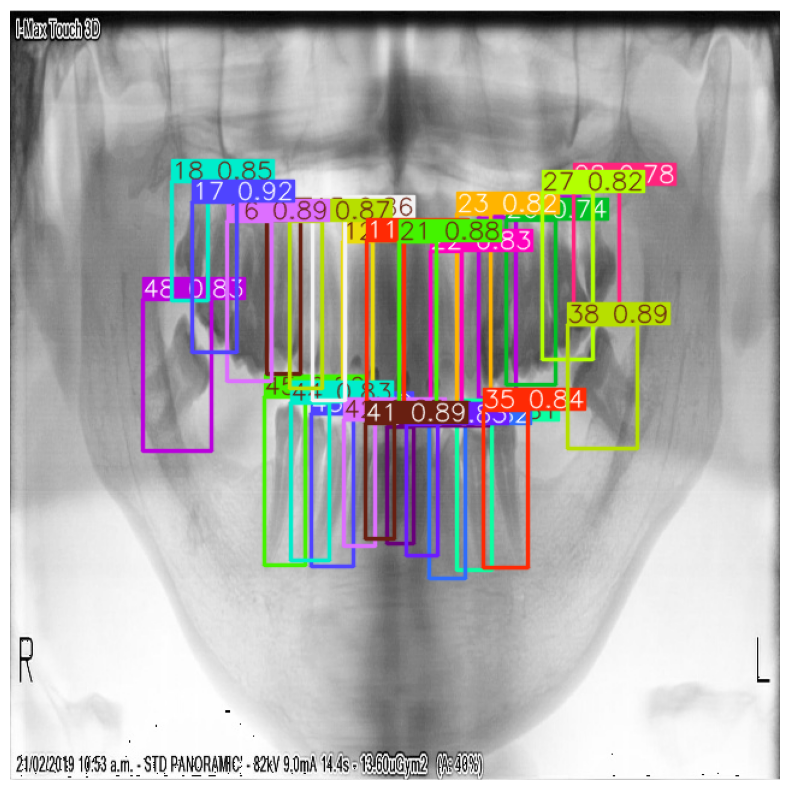

In [18]:
#!pip install ultralytics
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_path = '/content/drive/MyDrive/data_after_agu/test/images/213_jpg.rf.bf23d182f18ddc8b486e4619ca36532d.jpg'

model = YOLO('/content/drive/MyDrive/saved_models_after_agu/best.pt')


results = model.predict(source=image_path, imgsz=640, conf=0.5, iou=0.5)


detected_teeth = set()
for result in results:
    for box in result.boxes:
        class_id = int(box.cls)
        detected_teeth.add(class_id)

molars = {7, 6, 5, 13, 14, 15, 31, 30, 29, 21, 22, 23}
incisors = {0, 1, 8, 9, 24, 25, 16, 17}
canines = {2, 10, 18, 26}
premolars = {3, 4, 11, 12, 19, 20, 27, 28}

molar_count = len(detected_teeth.intersection(molars))
incisor_count = len(detected_teeth.intersection(incisors))
canine_count = len(detected_teeth.intersection(canines))
premolar_count = len(detected_teeth.intersection(premolars))

total_detected = min(len(detected_teeth), 32)
missing_teeth = max(32 - total_detected, 0)


missing_teeth_message = "No Missing Teeth" if missing_teeth == 0 else f"Total number of missing teeth: {missing_teeth} teeth"

output_message = f"""
Total number of teeth: {total_detected} teeth
        {incisor_count} incisors
        {canine_count} canines
        {premolar_count} premolars
        {molar_count} molars

{missing_teeth_message}
"""

print(output_message)


for result in results:
    plotted_image = result.plot()
    plt.figure(figsize=(10, 10))
    plt.imshow(plotted_image)
    plt.axis('off')
    plt.show()
